In [2]:
#imports 
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def make_moons(n_samples=100, noise=None, random_state=None):
    """Make two interleaving half circles.
    A simple toy dataset to visualize clustering and classification
    algorithms. Read more in the :ref:`User Guide <sample_generators>`.
    Parameters
    ----------
    n_samples : int or tuple of shape (2,), dtype=int, default=100
        If int, the total number of points generated.
        If two-element tuple, number of points in each of two moons.
    noise : float, default=None
        Standard deviation of Gaussian noise added to the data.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset shuffling and noise.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    X : ndarray of shape (n_samples, 2)
        The generated samples.
    y : ndarray of shape (n_samples,)
        The integer labels (0 or 1) for class membership of each sample.
    """

    if isinstance(n_samples, int):
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError as e:
            raise ValueError(
                "`n_samples` can be either an int or a two-element tuple."
            ) from e
    
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out)) # -1 to 1
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out)) # 0 to 1 to 0
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in)) # 0 to 2
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5 # -0.5 to 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y)]
    ).T
    y = np.hstack(
        [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
    )
    y = np.reshape(y,(-1,1))

    if noise is not None:
        np.random.seed(random_state)
        X += np.random.normal(0, noise, X.shape)

    label_proportion = 0.02  #####################################
    num_labeled = int(len(y)*label_proportion)
    xy = np.hstack([x,y])
    xy.shape
    np.random.seed(41) #######################################################
    np.random.shuffle(xy)
    
    x_labeled, y_labeled = xy[:num_labeled,:2] , xy[:num_labeled,-1]
    x_unlabeled, y_unlabeled = xy[num_labeled:, :2], xy[num_labeled:, -1]

    return x_labeled, x_unlabeled, y_labeled, y_unlabeled


x, y = make_moons(n_samples=1000, noise= 0.12, random_state=41)

In [67]:
# Create a scatter plot of the data
def plot_xy(X,y):
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Binary Classification Dataset')
  plt.show()

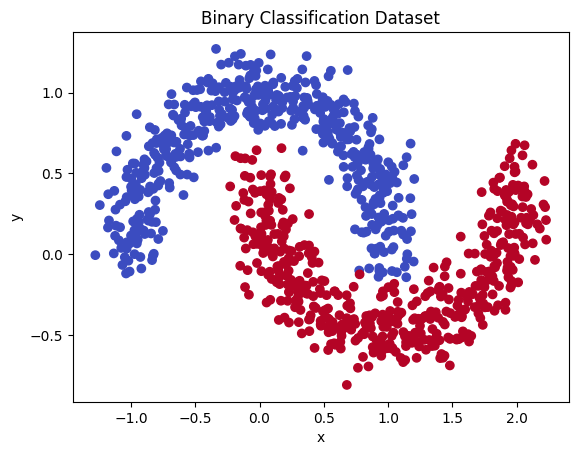

In [68]:
plot_xy(x,y)

In [96]:
label_proportion = 0.02
num_labeled = int(len(y)*label_proportion)
y = np.reshape(y,(-1,1))

xy = np.hstack([x,y])
xy.shape
np.random.seed(41) ### 
np.random.shuffle(xy,)

x_labeled, y_labeled = xy[:num_labeled,:2] , xy[:num_labeled,-1]
x_unlabeled, y_unlabeled = xy[num_labeled:, :2], xy[num_labeled:, -1]


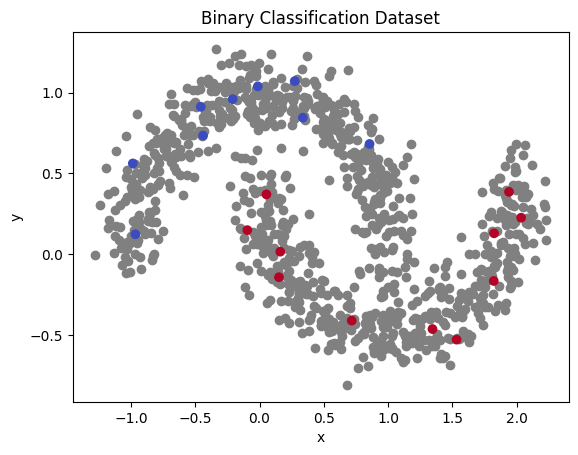

In [101]:
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c='gray')
plt.scatter(x_labeled[:, 0], x_labeled[:, 1], c=y_labeled, cmap='coolwarm')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Binary Classification Dataset')
plt.show()

In [75]:
def euc_distance(x,y):
    return np.exp(- np.linalg.norm((x-y),2))

dis = euc_distance(x,x)

((1000, 2), 1.0)